# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

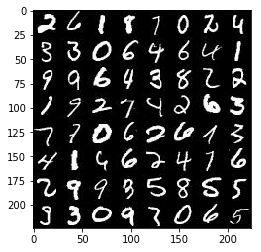

In [2]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

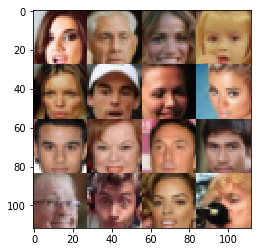

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    # create the placeholder for real_inputs. First dimension in tuple = 'None', which is confusing, but means
    # we can have ANY number of instances in the batch
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                name='inputs_real')
    
    # create the placeholder for the z inputs. These will be used by the generator to generate images
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    
    # create the learning rate.
    learn_rate = tf.placeholder(tf.float32, (None), name="learning_rate")
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # set my alpha value for the leaky relu - using the same as the Udacity DCGAN walkthrough
    alpha = 0.2
    # reviewer comment - try using dropout in discriminator with low rate of dropping
    # reviewer comment - try using xavier initialisation. NOTE for the discriminator, the only one that
    # is a fully connected layer is the first one, so this is the only one to initialise.
    dropout_rate = 0.95
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input layer is 28*28*3 for the celebs, 28*28*1 for the MNIST
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # don't apply the batch normalisation to the input layer
        relu1 = tf.maximum(alpha * x1, x1) # leaky relu
        # layer is now 14 * 14 * 64 (i.e. convoluted stack of 'images' of 14*14 across 64 filters)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        dropped2 = tf.nn.dropout(relu2, keep_prob=dropout_rate)
#         print('relu2.shape is {}'.format(relu2.shape))
        # layer is now 7 * 7 * 128
        
        x3 = tf.layers.conv2d(dropped2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        dropped3 = tf.nn.dropout(relu3, keep_prob=dropout_rate)
        print('relu3.shape is {}'.format(relu3.shape))
        # layer is now 4*4* 256 (or maybe 3*3? * 256)
        
        # Flatten this final tensor
        flat = tf.reshape(dropped3, (-1, 4*4*256)) # will find out here if my dimension calcs are correct
        print('flat.shape is {}'.format(flat.shape))
        logits = tf.layers.dense(flat, 1) # output to one because it is a simple yes/no as to whether it is a "True" pic
        out = tf.sigmoid(logits)
        
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Instructions for updating:
Use the retry module or similar alternatives.
relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # set my alpha level for the leaky relus - using the same as the Udacity DCGAN walk-through
    alpha = 0.2
    
    # reviewer comment - try using xavier intialisation for the weights. For the generator there are several
    # fully connected layers - use it for each?
    xavier_weights = tf.contrib.layers.xavier_initializer_conv2d()
    
    with tf.variable_scope("generator", reuse=not is_train):
        # this threw me for AGES - see Slack channel. You want to set reuse to True when is_training is False and
        # vice versa. When you are training you don't re-use the variables.
        
        # Reviewer suggestion - use 3 layers (previously had 2) - suggests 512, 256, 128 to output.
        
        # create first, fully connected layer
        x1_dense = tf.layers.dense(z, 7*7*512) # match the discriminator - work backwards
        
        # reshape it into a convolutional tensor and start the convolutional stack.
        x1 = tf.reshape(x1_dense, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training= is_train)
        relu1 = tf.maximum(alpha * bn1, bn1) # leaky relu
        #print("relu1.shape is {}".format(relu1.shape))
        # layer is 7 * 7 * 512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same', kernel_initializer=xavier_weights)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print("relu2.shape is {}".format(relu2.shape))
        # layer is now 14 * 14 * 256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same', kernel_initializer=xavier_weights)
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
#         print("relu3.shape is {}".format(relu3.shape))
        # layer is now 28 * 28  * 128
        
        # create the output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=xavier_weights)
        # this is how we solve for the different RGB channel dimension diffs between the MNIST and celeba
        # as the number of 'filters' is now the number of channels. Same thing.
        # Note we need to set the strides at 1, as the image shape is already 28 * 28 and we don't want to increase
        # it to 56*56.
        # layer is now 28 * 28 * 3 or 28 * 28 * 1
        #print('logits has shape: {}'.format(logits.shape))
        
        out = tf.tanh(logits)
    
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # reviewer #2 comment - try using smoothing on discriminator labels to improve performance
    smooth =0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels = tf.ones_like(d_model_real) * smooth)
    )
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels = tf.zeros_like(d_model_fake))
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    # reviewer comment - to try to prevent the discriminator from being too strong, only the discriminator labels
    # (one-sided) are reduced from 1 to 0.9. This is known as label smoothing.
    smooth = 0.1
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake) * (1 - smooth))
    ) 
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    tvars = tf.trainable_variables()
    
    d_vars = [var for var in tvars if var.name.startswith('discriminator')]
    #print(d_vars)
    g_vars = [var for var in tvars if var.name.startswith('generator')]
    #print(g_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt= tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt= tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     saver = tf.train.Saver()
    
    # create the inputs placeholders etc using the model_inputs function
    # see playground cell below to see how I found out the dimensions
    inputs_real, inputs_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # create the losses using the model_loss function
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    
    # optimize those losses using the model_opt() function
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate=learning_rate, beta1=beta1)

    losses = []
    # note - I have the losses in a list, but I don't actually return them at the end. This is because I don't
    # want to mess around with the Udacity cells when the code is run to generate figures etc. It's for future
    # projects, to remind me to store the losses to create graphs of training loss vs epochs
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                
                # TODO: Train Model
                # from Slack channel - the batch_images have data in range -0.5 to +0.5, so double them to get the image
                batch_images = batch_images *2
                
                
                # create random noise z_inputs to seed the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images,
                                                   inputs_z: batch_z,
                                                   learn_rate: learning_rate
                })
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images,
                                                    inputs_z: batch_z,
                                                    learn_rate: learning_rate
                    
                })
                
                # calculate loss every 25 batches?
                if steps % 25 == 0:
                    train_loss_d = d_loss.eval(feed_dict={
                        inputs_real: batch_images,
                        inputs_z: batch_z
                    })
                    train_loss_g = g_loss.eval(feed_dict={
                        inputs_z: batch_z
                    })
                    print('Epoch: {}'.format(epoch_i + 1), end=", ")
                    print('Batch: {}'.format(steps), end=": ")
                    print('Discr train loss: {:.3f}'.format(train_loss_d), end=", ")
                    print('Gen train loss: {:.3f}'.format(train_loss_g))
                    
                    # save losses to view after training:
                    losses.append((train_loss_d, train_loss_g))
                
                # show the images created every 100 batches?
                if steps % 100 == 0:
                    # as per instructions, run the show_generator_output every 100 batches
                    show_generator_output(sess, n_images=36, input_z=inputs_z, out_channel_dim=data_shape[3],
                                         image_mode=data_image_mode)
        #saver.save(sess, './checkpoints/generator.ckpt')
                

In [12]:
# DCFW created playground cell to find out attributes etc.
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print (mnist_dataset.shape) # finding the dimensions - need this for the inputs

(60000, 28, 28, 1)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

following comments from reviewer, looked at [Radford paper](https://arxiv.org/abs/1511.06434) for hyperparameter suggestions.

relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
Epoch: 1, Batch: 25: Discr train loss: 0.534, Gen train loss: 2.090
Epoch: 1, Batch: 50: Discr train loss: 2.342, Gen train loss: 0.369
Epoch: 1, Batch: 75: Discr train loss: 1.743, Gen train loss: 0.617
Epoch: 1, Batch: 100: Discr train loss: 1.657, Gen train loss: 0.898


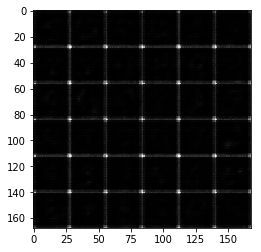

Epoch: 1, Batch: 125: Discr train loss: 1.620, Gen train loss: 0.751
Epoch: 1, Batch: 150: Discr train loss: 1.550, Gen train loss: 0.489
Epoch: 1, Batch: 175: Discr train loss: 1.293, Gen train loss: 0.863
Epoch: 1, Batch: 200: Discr train loss: 1.169, Gen train loss: 0.985


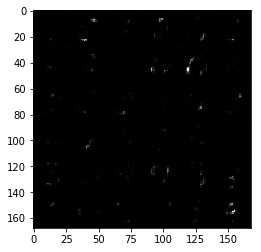

Epoch: 1, Batch: 225: Discr train loss: 1.345, Gen train loss: 0.596
Epoch: 1, Batch: 250: Discr train loss: 1.310, Gen train loss: 0.580
Epoch: 1, Batch: 275: Discr train loss: 1.341, Gen train loss: 0.645
Epoch: 1, Batch: 300: Discr train loss: 1.131, Gen train loss: 1.645


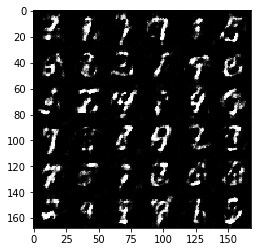

Epoch: 1, Batch: 325: Discr train loss: 1.043, Gen train loss: 1.473
Epoch: 1, Batch: 350: Discr train loss: 1.948, Gen train loss: 0.441
Epoch: 1, Batch: 375: Discr train loss: 1.696, Gen train loss: 0.478
Epoch: 1, Batch: 400: Discr train loss: 1.839, Gen train loss: 0.437


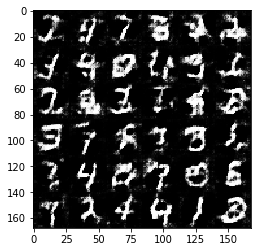

Epoch: 1, Batch: 425: Discr train loss: 1.329, Gen train loss: 0.605
Epoch: 1, Batch: 450: Discr train loss: 1.200, Gen train loss: 0.908
Epoch: 1, Batch: 475: Discr train loss: 1.515, Gen train loss: 0.527
Epoch: 1, Batch: 500: Discr train loss: 1.336, Gen train loss: 0.620


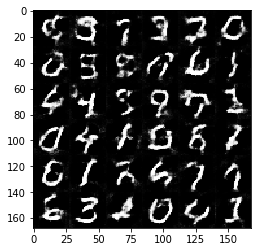

Epoch: 1, Batch: 525: Discr train loss: 1.257, Gen train loss: 1.189
Epoch: 1, Batch: 550: Discr train loss: 1.201, Gen train loss: 0.699
Epoch: 1, Batch: 575: Discr train loss: 1.286, Gen train loss: 0.693
Epoch: 1, Batch: 600: Discr train loss: 1.215, Gen train loss: 1.170


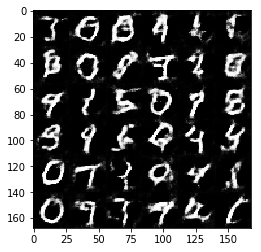

Epoch: 1, Batch: 625: Discr train loss: 1.248, Gen train loss: 0.809
Epoch: 1, Batch: 650: Discr train loss: 1.114, Gen train loss: 0.875
Epoch: 1, Batch: 675: Discr train loss: 1.187, Gen train loss: 0.811
Epoch: 1, Batch: 700: Discr train loss: 1.241, Gen train loss: 0.718


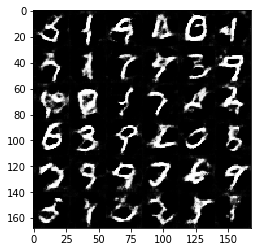

Epoch: 1, Batch: 725: Discr train loss: 1.258, Gen train loss: 0.617
Epoch: 1, Batch: 750: Discr train loss: 1.335, Gen train loss: 0.608
Epoch: 1, Batch: 775: Discr train loss: 1.178, Gen train loss: 0.999
Epoch: 1, Batch: 800: Discr train loss: 1.290, Gen train loss: 0.701


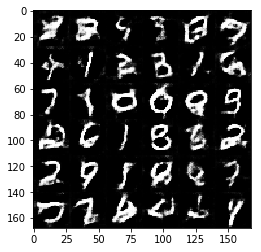

Epoch: 1, Batch: 825: Discr train loss: 1.150, Gen train loss: 1.326
Epoch: 1, Batch: 850: Discr train loss: 1.208, Gen train loss: 0.895
Epoch: 1, Batch: 875: Discr train loss: 1.146, Gen train loss: 0.997
Epoch: 1, Batch: 900: Discr train loss: 1.052, Gen train loss: 1.402


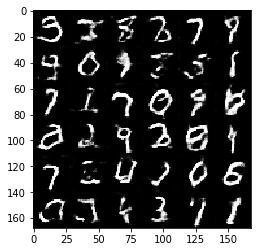

Epoch: 1, Batch: 925: Discr train loss: 1.138, Gen train loss: 1.014
Epoch: 1, Batch: 950: Discr train loss: 1.636, Gen train loss: 0.474
Epoch: 1, Batch: 975: Discr train loss: 1.118, Gen train loss: 0.977
Epoch: 1, Batch: 1000: Discr train loss: 1.206, Gen train loss: 0.847


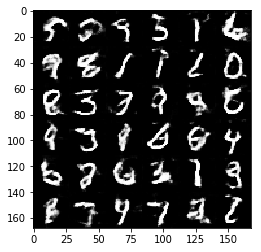

Epoch: 1, Batch: 1025: Discr train loss: 1.176, Gen train loss: 1.037
Epoch: 1, Batch: 1050: Discr train loss: 1.056, Gen train loss: 0.905
Epoch: 1, Batch: 1075: Discr train loss: 1.298, Gen train loss: 0.649
Epoch: 1, Batch: 1100: Discr train loss: 1.055, Gen train loss: 0.823


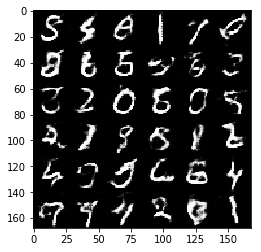

Epoch: 1, Batch: 1125: Discr train loss: 1.013, Gen train loss: 0.964
Epoch: 1, Batch: 1150: Discr train loss: 1.054, Gen train loss: 0.897
Epoch: 1, Batch: 1175: Discr train loss: 1.010, Gen train loss: 1.206
Epoch: 1, Batch: 1200: Discr train loss: 1.121, Gen train loss: 0.849


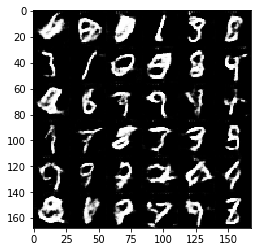

Epoch: 1, Batch: 1225: Discr train loss: 1.120, Gen train loss: 1.079
Epoch: 1, Batch: 1250: Discr train loss: 1.111, Gen train loss: 0.823
Epoch: 1, Batch: 1275: Discr train loss: 1.189, Gen train loss: 0.713
Epoch: 1, Batch: 1300: Discr train loss: 1.066, Gen train loss: 0.883


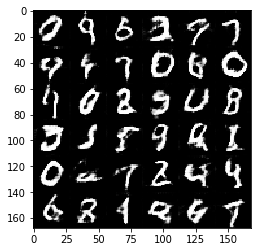

Epoch: 1, Batch: 1325: Discr train loss: 1.183, Gen train loss: 0.780
Epoch: 1, Batch: 1350: Discr train loss: 1.181, Gen train loss: 0.728
Epoch: 1, Batch: 1375: Discr train loss: 1.137, Gen train loss: 1.134
Epoch: 1, Batch: 1400: Discr train loss: 1.292, Gen train loss: 0.795


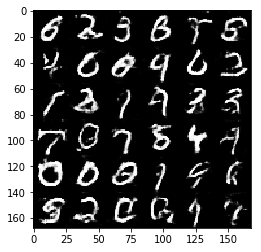

Epoch: 1, Batch: 1425: Discr train loss: 1.165, Gen train loss: 1.145
Epoch: 1, Batch: 1450: Discr train loss: 1.013, Gen train loss: 0.883
Epoch: 1, Batch: 1475: Discr train loss: 1.517, Gen train loss: 0.529
Epoch: 1, Batch: 1500: Discr train loss: 1.151, Gen train loss: 0.792


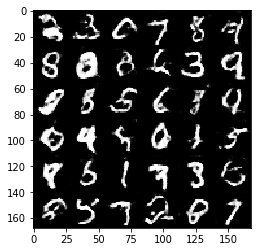

Epoch: 1, Batch: 1525: Discr train loss: 1.300, Gen train loss: 0.592
Epoch: 1, Batch: 1550: Discr train loss: 1.094, Gen train loss: 0.862
Epoch: 1, Batch: 1575: Discr train loss: 1.312, Gen train loss: 0.565
Epoch: 1, Batch: 1600: Discr train loss: 1.337, Gen train loss: 0.551


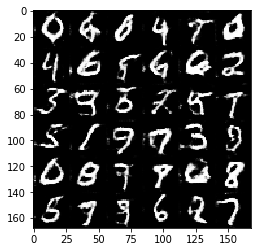

Epoch: 1, Batch: 1625: Discr train loss: 0.995, Gen train loss: 1.261
Epoch: 1, Batch: 1650: Discr train loss: 1.856, Gen train loss: 0.433
Epoch: 1, Batch: 1675: Discr train loss: 1.091, Gen train loss: 1.086
Epoch: 1, Batch: 1700: Discr train loss: 2.249, Gen train loss: 0.375


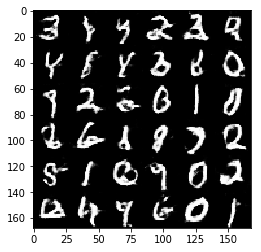

Epoch: 1, Batch: 1725: Discr train loss: 1.148, Gen train loss: 0.776
Epoch: 1, Batch: 1750: Discr train loss: 0.918, Gen train loss: 1.194
Epoch: 1, Batch: 1775: Discr train loss: 0.949, Gen train loss: 1.228
Epoch: 1, Batch: 1800: Discr train loss: 1.311, Gen train loss: 1.303


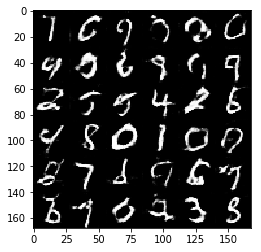

Epoch: 1, Batch: 1825: Discr train loss: 1.298, Gen train loss: 0.812
Epoch: 1, Batch: 1850: Discr train loss: 1.047, Gen train loss: 1.187
Epoch: 1, Batch: 1875: Discr train loss: 0.847, Gen train loss: 1.124
Epoch: 2, Batch: 1900: Discr train loss: 0.882, Gen train loss: 1.020


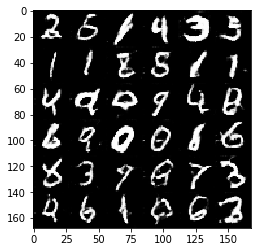

Epoch: 2, Batch: 1925: Discr train loss: 1.089, Gen train loss: 0.781
Epoch: 2, Batch: 1950: Discr train loss: 0.989, Gen train loss: 0.956
Epoch: 2, Batch: 1975: Discr train loss: 0.887, Gen train loss: 1.167
Epoch: 2, Batch: 2000: Discr train loss: 1.250, Gen train loss: 0.722


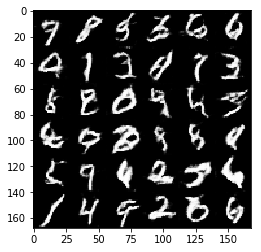

Epoch: 2, Batch: 2025: Discr train loss: 1.179, Gen train loss: 0.787
Epoch: 2, Batch: 2050: Discr train loss: 0.887, Gen train loss: 1.249
Epoch: 2, Batch: 2075: Discr train loss: 0.885, Gen train loss: 1.033
Epoch: 2, Batch: 2100: Discr train loss: 0.878, Gen train loss: 0.966


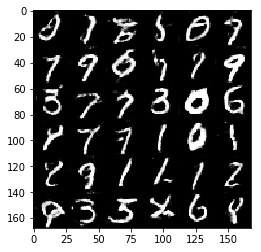

Epoch: 2, Batch: 2125: Discr train loss: 0.987, Gen train loss: 0.929
Epoch: 2, Batch: 2150: Discr train loss: 1.642, Gen train loss: 0.471
Epoch: 2, Batch: 2175: Discr train loss: 0.953, Gen train loss: 1.066
Epoch: 2, Batch: 2200: Discr train loss: 0.912, Gen train loss: 1.294


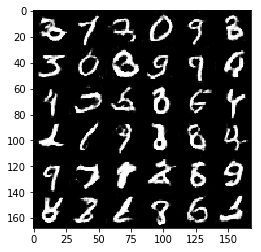

Epoch: 2, Batch: 2225: Discr train loss: 2.060, Gen train loss: 0.369
Epoch: 2, Batch: 2250: Discr train loss: 0.754, Gen train loss: 1.351
Epoch: 2, Batch: 2275: Discr train loss: 1.032, Gen train loss: 1.450
Epoch: 2, Batch: 2300: Discr train loss: 0.931, Gen train loss: 1.449


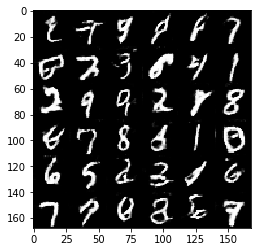

Epoch: 2, Batch: 2325: Discr train loss: 1.252, Gen train loss: 0.634
Epoch: 2, Batch: 2350: Discr train loss: 0.908, Gen train loss: 1.159
Epoch: 2, Batch: 2375: Discr train loss: 1.069, Gen train loss: 0.793
Epoch: 2, Batch: 2400: Discr train loss: 1.127, Gen train loss: 0.815


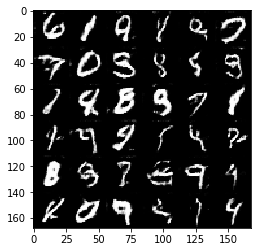

Epoch: 2, Batch: 2425: Discr train loss: 0.708, Gen train loss: 1.852
Epoch: 2, Batch: 2450: Discr train loss: 0.823, Gen train loss: 1.327
Epoch: 2, Batch: 2475: Discr train loss: 1.489, Gen train loss: 0.608
Epoch: 2, Batch: 2500: Discr train loss: 0.935, Gen train loss: 1.090


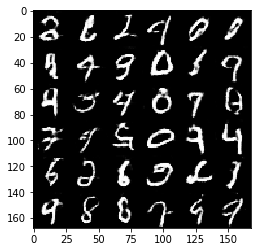

Epoch: 2, Batch: 2525: Discr train loss: 0.922, Gen train loss: 0.927
Epoch: 2, Batch: 2550: Discr train loss: 1.150, Gen train loss: 1.370
Epoch: 2, Batch: 2575: Discr train loss: 1.211, Gen train loss: 0.729
Epoch: 2, Batch: 2600: Discr train loss: 0.846, Gen train loss: 0.999


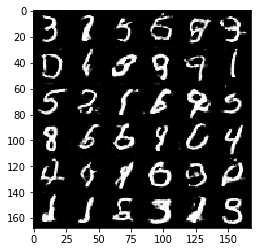

Epoch: 2, Batch: 2625: Discr train loss: 0.896, Gen train loss: 0.962
Epoch: 2, Batch: 2650: Discr train loss: 0.896, Gen train loss: 1.038
Epoch: 2, Batch: 2675: Discr train loss: 0.906, Gen train loss: 1.035
Epoch: 2, Batch: 2700: Discr train loss: 0.699, Gen train loss: 1.434


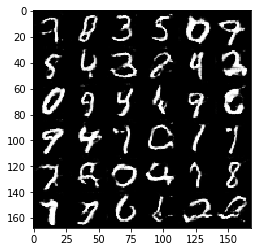

Epoch: 2, Batch: 2725: Discr train loss: 0.864, Gen train loss: 1.591
Epoch: 2, Batch: 2750: Discr train loss: 0.929, Gen train loss: 1.488
Epoch: 2, Batch: 2775: Discr train loss: 1.075, Gen train loss: 0.809
Epoch: 2, Batch: 2800: Discr train loss: 1.111, Gen train loss: 1.944


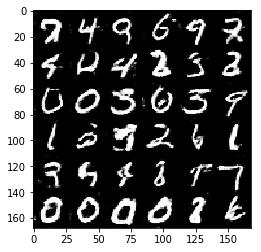

Epoch: 2, Batch: 2825: Discr train loss: 0.911, Gen train loss: 1.299
Epoch: 2, Batch: 2850: Discr train loss: 0.739, Gen train loss: 1.268
Epoch: 2, Batch: 2875: Discr train loss: 1.070, Gen train loss: 2.247
Epoch: 2, Batch: 2900: Discr train loss: 0.879, Gen train loss: 1.038


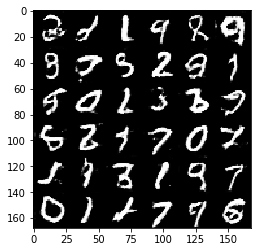

Epoch: 2, Batch: 2925: Discr train loss: 0.870, Gen train loss: 1.426
Epoch: 2, Batch: 2950: Discr train loss: 0.961, Gen train loss: 0.958
Epoch: 2, Batch: 2975: Discr train loss: 0.934, Gen train loss: 1.131
Epoch: 2, Batch: 3000: Discr train loss: 1.358, Gen train loss: 2.436


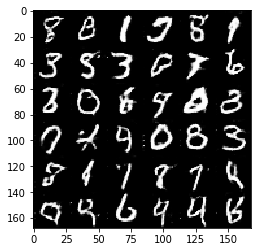

Epoch: 2, Batch: 3025: Discr train loss: 0.812, Gen train loss: 1.853
Epoch: 2, Batch: 3050: Discr train loss: 0.748, Gen train loss: 1.407
Epoch: 2, Batch: 3075: Discr train loss: 1.655, Gen train loss: 0.533
Epoch: 2, Batch: 3100: Discr train loss: 1.637, Gen train loss: 0.542


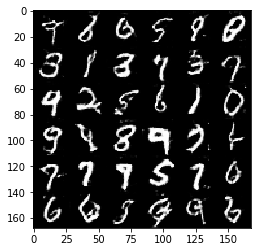

Epoch: 2, Batch: 3125: Discr train loss: 0.765, Gen train loss: 1.178
Epoch: 2, Batch: 3150: Discr train loss: 0.733, Gen train loss: 1.324
Epoch: 2, Batch: 3175: Discr train loss: 1.700, Gen train loss: 2.408
Epoch: 2, Batch: 3200: Discr train loss: 0.633, Gen train loss: 1.623


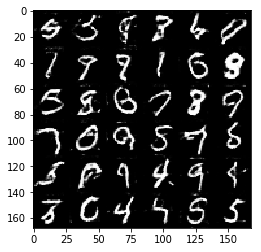

Epoch: 2, Batch: 3225: Discr train loss: 0.907, Gen train loss: 2.074
Epoch: 2, Batch: 3250: Discr train loss: 0.602, Gen train loss: 1.438
Epoch: 2, Batch: 3275: Discr train loss: 0.725, Gen train loss: 1.424
Epoch: 2, Batch: 3300: Discr train loss: 1.287, Gen train loss: 0.583


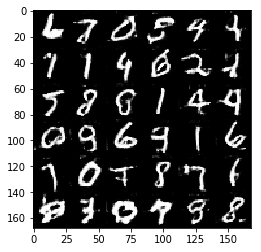

Epoch: 2, Batch: 3325: Discr train loss: 0.894, Gen train loss: 1.649
Epoch: 2, Batch: 3350: Discr train loss: 1.057, Gen train loss: 0.875
Epoch: 2, Batch: 3375: Discr train loss: 0.831, Gen train loss: 1.686
Epoch: 2, Batch: 3400: Discr train loss: 0.943, Gen train loss: 1.019


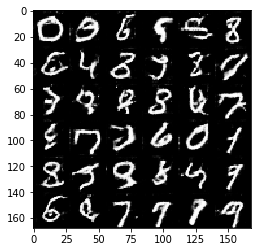

Epoch: 2, Batch: 3425: Discr train loss: 0.871, Gen train loss: 1.074
Epoch: 2, Batch: 3450: Discr train loss: 1.217, Gen train loss: 0.652
Epoch: 2, Batch: 3475: Discr train loss: 0.748, Gen train loss: 1.396
Epoch: 2, Batch: 3500: Discr train loss: 0.858, Gen train loss: 1.223


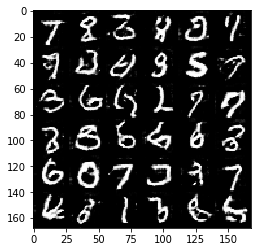

Epoch: 2, Batch: 3525: Discr train loss: 1.213, Gen train loss: 0.777
Epoch: 2, Batch: 3550: Discr train loss: 0.928, Gen train loss: 0.856
Epoch: 2, Batch: 3575: Discr train loss: 1.031, Gen train loss: 2.156
Epoch: 2, Batch: 3600: Discr train loss: 1.431, Gen train loss: 0.627


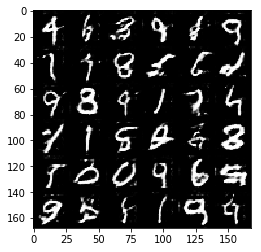

Epoch: 2, Batch: 3625: Discr train loss: 1.145, Gen train loss: 0.782
Epoch: 2, Batch: 3650: Discr train loss: 0.914, Gen train loss: 1.001
Epoch: 2, Batch: 3675: Discr train loss: 1.150, Gen train loss: 0.771
Epoch: 2, Batch: 3700: Discr train loss: 0.809, Gen train loss: 1.293


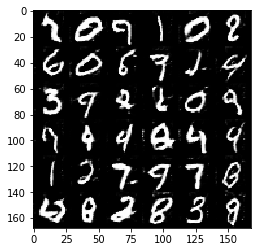

Epoch: 2, Batch: 3725: Discr train loss: 1.072, Gen train loss: 0.730
Epoch: 2, Batch: 3750: Discr train loss: 1.077, Gen train loss: 0.874


In [13]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
Epoch: 1, Batch: 25: Discr train loss: 2.830, Gen train loss: 0.403
Epoch: 1, Batch: 50: Discr train loss: 0.836, Gen train loss: 1.582
Epoch: 1, Batch: 75: Discr train loss: 0.954, Gen train loss: 0.975
Epoch: 1, Batch: 100: Discr train loss: 1.824, Gen train loss: 0.501


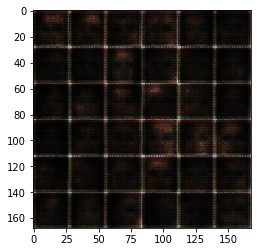

Epoch: 1, Batch: 125: Discr train loss: 0.731, Gen train loss: 1.541
Epoch: 1, Batch: 150: Discr train loss: 0.582, Gen train loss: 1.637
Epoch: 1, Batch: 175: Discr train loss: 0.924, Gen train loss: 0.968
Epoch: 1, Batch: 200: Discr train loss: 0.452, Gen train loss: 2.895


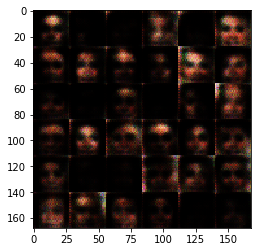

Epoch: 1, Batch: 225: Discr train loss: 0.784, Gen train loss: 1.268
Epoch: 1, Batch: 250: Discr train loss: 3.242, Gen train loss: 4.846
Epoch: 1, Batch: 275: Discr train loss: 0.893, Gen train loss: 4.696
Epoch: 1, Batch: 300: Discr train loss: 0.547, Gen train loss: 1.885


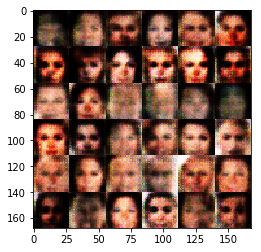

Epoch: 1, Batch: 325: Discr train loss: 1.588, Gen train loss: 0.515
Epoch: 1, Batch: 350: Discr train loss: 1.630, Gen train loss: 0.482
Epoch: 1, Batch: 375: Discr train loss: 0.938, Gen train loss: 1.021
Epoch: 1, Batch: 400: Discr train loss: 1.978, Gen train loss: 0.431


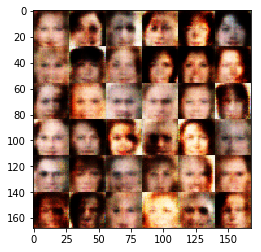

Epoch: 1, Batch: 425: Discr train loss: 1.232, Gen train loss: 0.646
Epoch: 1, Batch: 450: Discr train loss: 1.147, Gen train loss: 0.782
Epoch: 1, Batch: 475: Discr train loss: 1.292, Gen train loss: 0.662
Epoch: 1, Batch: 500: Discr train loss: 0.536, Gen train loss: 2.597


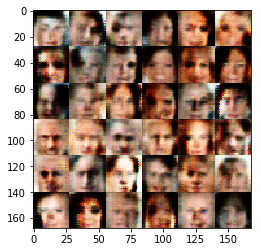

Epoch: 1, Batch: 525: Discr train loss: 1.256, Gen train loss: 0.654
Epoch: 1, Batch: 550: Discr train loss: 0.771, Gen train loss: 1.567
Epoch: 1, Batch: 575: Discr train loss: 0.884, Gen train loss: 1.070
Epoch: 1, Batch: 600: Discr train loss: 0.750, Gen train loss: 2.704


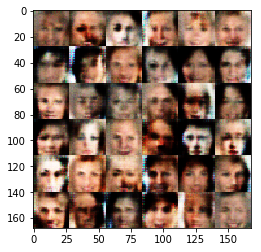

Epoch: 1, Batch: 625: Discr train loss: 1.582, Gen train loss: 0.480
Epoch: 1, Batch: 650: Discr train loss: 0.758, Gen train loss: 1.387
Epoch: 1, Batch: 675: Discr train loss: 0.868, Gen train loss: 1.039
Epoch: 1, Batch: 700: Discr train loss: 0.867, Gen train loss: 1.106


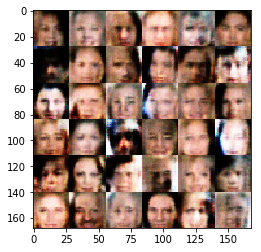

Epoch: 1, Batch: 725: Discr train loss: 1.096, Gen train loss: 1.294
Epoch: 1, Batch: 750: Discr train loss: 1.170, Gen train loss: 2.975
Epoch: 1, Batch: 775: Discr train loss: 0.980, Gen train loss: 0.909
Epoch: 1, Batch: 800: Discr train loss: 0.659, Gen train loss: 1.510


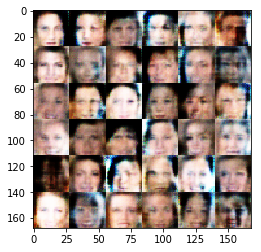

Epoch: 1, Batch: 825: Discr train loss: 0.727, Gen train loss: 1.529
Epoch: 1, Batch: 850: Discr train loss: 1.646, Gen train loss: 2.098
Epoch: 1, Batch: 875: Discr train loss: 1.289, Gen train loss: 0.638
Epoch: 1, Batch: 900: Discr train loss: 1.381, Gen train loss: 1.371


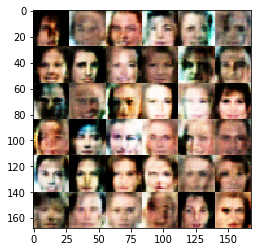

Epoch: 1, Batch: 925: Discr train loss: 1.484, Gen train loss: 1.047
Epoch: 1, Batch: 950: Discr train loss: 1.385, Gen train loss: 0.552
Epoch: 1, Batch: 975: Discr train loss: 0.837, Gen train loss: 1.362
Epoch: 1, Batch: 1000: Discr train loss: 1.490, Gen train loss: 0.522


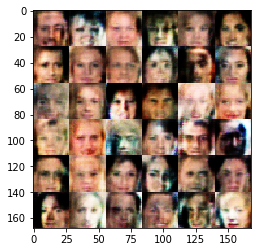

Epoch: 1, Batch: 1025: Discr train loss: 1.248, Gen train loss: 1.083
Epoch: 1, Batch: 1050: Discr train loss: 0.754, Gen train loss: 1.137
Epoch: 1, Batch: 1075: Discr train loss: 0.690, Gen train loss: 2.121
Epoch: 1, Batch: 1100: Discr train loss: 1.283, Gen train loss: 1.985


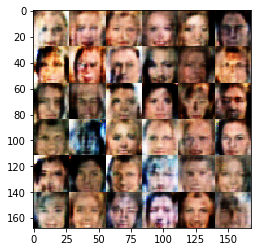

Epoch: 1, Batch: 1125: Discr train loss: 0.801, Gen train loss: 3.031
Epoch: 1, Batch: 1150: Discr train loss: 0.559, Gen train loss: 1.724
Epoch: 1, Batch: 1175: Discr train loss: 0.850, Gen train loss: 1.100
Epoch: 1, Batch: 1200: Discr train loss: 0.772, Gen train loss: 1.205


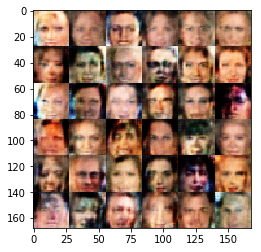

Epoch: 1, Batch: 1225: Discr train loss: 0.544, Gen train loss: 3.080
Epoch: 1, Batch: 1250: Discr train loss: 1.296, Gen train loss: 0.601
Epoch: 1, Batch: 1275: Discr train loss: 1.167, Gen train loss: 0.805
Epoch: 1, Batch: 1300: Discr train loss: 1.029, Gen train loss: 1.877


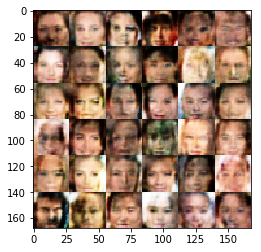

Epoch: 1, Batch: 1325: Discr train loss: 0.687, Gen train loss: 1.618
Epoch: 1, Batch: 1350: Discr train loss: 1.318, Gen train loss: 0.985
Epoch: 1, Batch: 1375: Discr train loss: 0.614, Gen train loss: 2.613
Epoch: 1, Batch: 1400: Discr train loss: 1.517, Gen train loss: 0.510


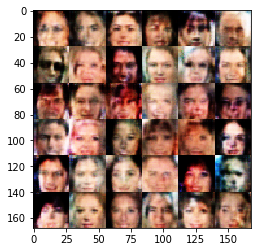

Epoch: 1, Batch: 1425: Discr train loss: 0.789, Gen train loss: 2.624
Epoch: 1, Batch: 1450: Discr train loss: 1.378, Gen train loss: 2.131
Epoch: 1, Batch: 1475: Discr train loss: 0.606, Gen train loss: 1.733
Epoch: 1, Batch: 1500: Discr train loss: 1.086, Gen train loss: 0.900


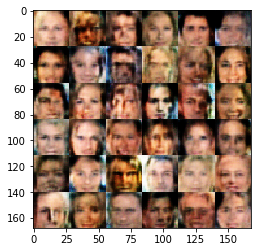

Epoch: 1, Batch: 1525: Discr train loss: 0.656, Gen train loss: 1.923
Epoch: 1, Batch: 1550: Discr train loss: 0.700, Gen train loss: 1.275
Epoch: 1, Batch: 1575: Discr train loss: 0.860, Gen train loss: 1.153
Epoch: 1, Batch: 1600: Discr train loss: 0.771, Gen train loss: 1.585


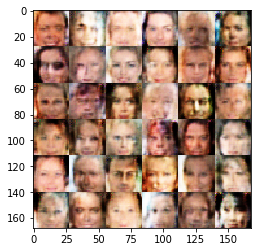

Epoch: 1, Batch: 1625: Discr train loss: 0.505, Gen train loss: 2.951
Epoch: 1, Batch: 1650: Discr train loss: 1.667, Gen train loss: 0.452
Epoch: 1, Batch: 1675: Discr train loss: 0.524, Gen train loss: 2.394
Epoch: 1, Batch: 1700: Discr train loss: 0.828, Gen train loss: 1.085


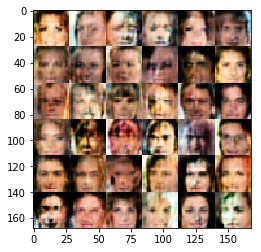

Epoch: 1, Batch: 1725: Discr train loss: 2.677, Gen train loss: 0.338
Epoch: 1, Batch: 1750: Discr train loss: 0.493, Gen train loss: 2.352
Epoch: 1, Batch: 1775: Discr train loss: 0.610, Gen train loss: 1.598
Epoch: 1, Batch: 1800: Discr train loss: 1.429, Gen train loss: 0.720


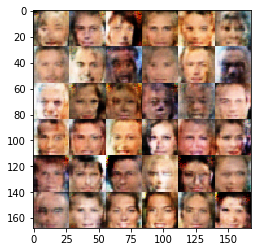

Epoch: 1, Batch: 1825: Discr train loss: 0.867, Gen train loss: 1.149
Epoch: 1, Batch: 1850: Discr train loss: 1.225, Gen train loss: 0.690
Epoch: 1, Batch: 1875: Discr train loss: 1.165, Gen train loss: 1.349
Epoch: 1, Batch: 1900: Discr train loss: 1.082, Gen train loss: 3.025


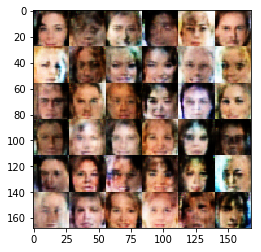

Epoch: 1, Batch: 1925: Discr train loss: 1.503, Gen train loss: 0.513
Epoch: 1, Batch: 1950: Discr train loss: 1.403, Gen train loss: 2.867
Epoch: 1, Batch: 1975: Discr train loss: 0.949, Gen train loss: 2.284
Epoch: 1, Batch: 2000: Discr train loss: 0.917, Gen train loss: 0.903


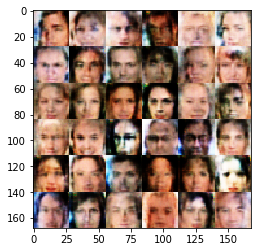

Epoch: 1, Batch: 2025: Discr train loss: 1.385, Gen train loss: 0.575
Epoch: 1, Batch: 2050: Discr train loss: 1.137, Gen train loss: 0.870
Epoch: 1, Batch: 2075: Discr train loss: 1.212, Gen train loss: 0.718
Epoch: 1, Batch: 2100: Discr train loss: 0.405, Gen train loss: 2.979


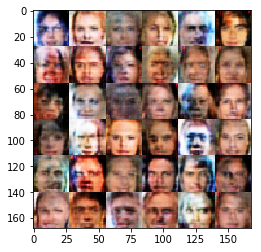

Epoch: 1, Batch: 2125: Discr train loss: 1.411, Gen train loss: 0.734
Epoch: 1, Batch: 2150: Discr train loss: 0.430, Gen train loss: 2.627
Epoch: 1, Batch: 2175: Discr train loss: 0.659, Gen train loss: 2.852
Epoch: 1, Batch: 2200: Discr train loss: 0.975, Gen train loss: 2.444


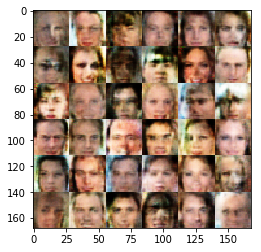

Epoch: 1, Batch: 2225: Discr train loss: 1.227, Gen train loss: 0.940
Epoch: 1, Batch: 2250: Discr train loss: 0.683, Gen train loss: 2.033
Epoch: 1, Batch: 2275: Discr train loss: 1.058, Gen train loss: 1.132
Epoch: 1, Batch: 2300: Discr train loss: 1.325, Gen train loss: 0.865


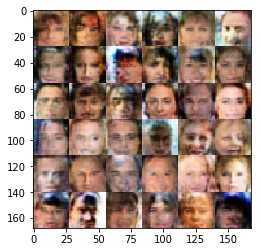

Epoch: 1, Batch: 2325: Discr train loss: 1.383, Gen train loss: 0.773
Epoch: 1, Batch: 2350: Discr train loss: 1.218, Gen train loss: 0.928
Epoch: 1, Batch: 2375: Discr train loss: 1.262, Gen train loss: 0.868
Epoch: 1, Batch: 2400: Discr train loss: 1.230, Gen train loss: 0.772


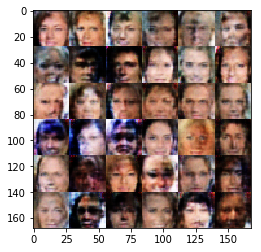

Epoch: 1, Batch: 2425: Discr train loss: 0.787, Gen train loss: 1.185
Epoch: 1, Batch: 2450: Discr train loss: 0.654, Gen train loss: 2.928
Epoch: 1, Batch: 2475: Discr train loss: 1.580, Gen train loss: 0.458
Epoch: 1, Batch: 2500: Discr train loss: 1.150, Gen train loss: 1.056


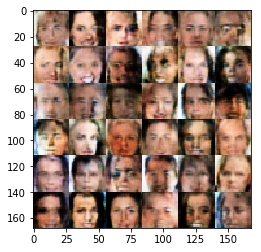

Epoch: 1, Batch: 2525: Discr train loss: 0.754, Gen train loss: 1.093
Epoch: 1, Batch: 2550: Discr train loss: 1.090, Gen train loss: 0.814
Epoch: 1, Batch: 2575: Discr train loss: 1.360, Gen train loss: 1.531
Epoch: 1, Batch: 2600: Discr train loss: 1.567, Gen train loss: 0.466


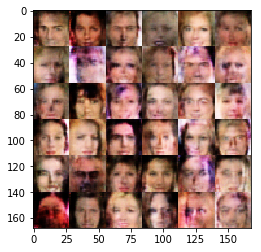

Epoch: 1, Batch: 2625: Discr train loss: 1.087, Gen train loss: 1.052
Epoch: 1, Batch: 2650: Discr train loss: 0.412, Gen train loss: 2.792
Epoch: 1, Batch: 2675: Discr train loss: 0.487, Gen train loss: 2.408
Epoch: 1, Batch: 2700: Discr train loss: 0.597, Gen train loss: 1.822


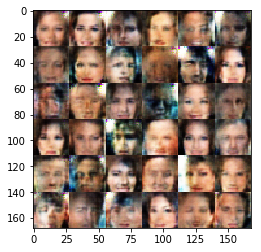

Epoch: 1, Batch: 2725: Discr train loss: 0.800, Gen train loss: 5.757
Epoch: 1, Batch: 2750: Discr train loss: 0.855, Gen train loss: 1.095
Epoch: 1, Batch: 2775: Discr train loss: 0.369, Gen train loss: 3.538
Epoch: 1, Batch: 2800: Discr train loss: 0.356, Gen train loss: 4.448


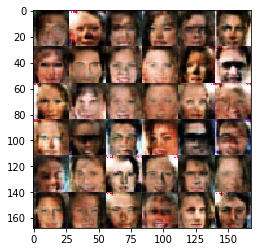

Epoch: 1, Batch: 2825: Discr train loss: 0.361, Gen train loss: 5.352
Epoch: 1, Batch: 2850: Discr train loss: 0.708, Gen train loss: 1.435
Epoch: 1, Batch: 2875: Discr train loss: 0.776, Gen train loss: 1.425
Epoch: 1, Batch: 2900: Discr train loss: 1.333, Gen train loss: 0.767


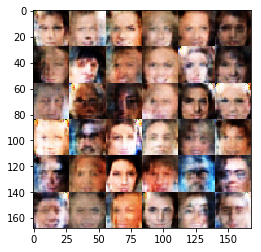

Epoch: 1, Batch: 2925: Discr train loss: 0.448, Gen train loss: 3.915
Epoch: 1, Batch: 2950: Discr train loss: 1.121, Gen train loss: 0.842
Epoch: 1, Batch: 2975: Discr train loss: 0.496, Gen train loss: 1.998
Epoch: 1, Batch: 3000: Discr train loss: 0.735, Gen train loss: 1.730


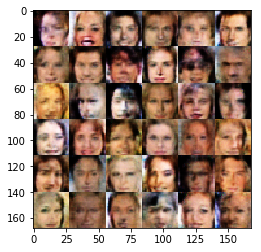

Epoch: 1, Batch: 3025: Discr train loss: 0.942, Gen train loss: 0.951
Epoch: 1, Batch: 3050: Discr train loss: 1.497, Gen train loss: 0.483
Epoch: 1, Batch: 3075: Discr train loss: 2.092, Gen train loss: 0.404
Epoch: 1, Batch: 3100: Discr train loss: 0.967, Gen train loss: 0.873


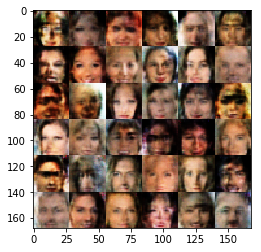

Epoch: 1, Batch: 3125: Discr train loss: 0.596, Gen train loss: 3.581
Epoch: 1, Batch: 3150: Discr train loss: 1.306, Gen train loss: 1.154
Epoch: 1, Batch: 3175: Discr train loss: 0.561, Gen train loss: 2.525
Epoch: 1, Batch: 3200: Discr train loss: 0.956, Gen train loss: 0.883


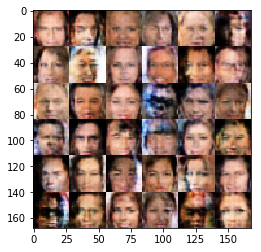

Epoch: 1, Batch: 3225: Discr train loss: 1.070, Gen train loss: 1.902
Epoch: 1, Batch: 3250: Discr train loss: 1.119, Gen train loss: 0.718
Epoch: 1, Batch: 3275: Discr train loss: 1.883, Gen train loss: 2.112
Epoch: 1, Batch: 3300: Discr train loss: 1.856, Gen train loss: 0.423


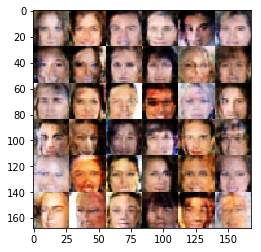

Epoch: 1, Batch: 3325: Discr train loss: 0.685, Gen train loss: 1.740
Epoch: 1, Batch: 3350: Discr train loss: 0.839, Gen train loss: 1.253
Epoch: 1, Batch: 3375: Discr train loss: 1.029, Gen train loss: 0.864
Epoch: 1, Batch: 3400: Discr train loss: 0.668, Gen train loss: 1.282


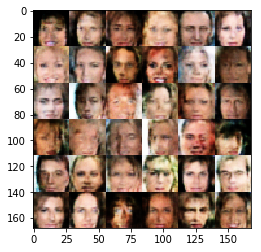

Epoch: 1, Batch: 3425: Discr train loss: 1.217, Gen train loss: 0.884
Epoch: 1, Batch: 3450: Discr train loss: 1.233, Gen train loss: 1.343
Epoch: 1, Batch: 3475: Discr train loss: 0.823, Gen train loss: 1.151
Epoch: 1, Batch: 3500: Discr train loss: 0.781, Gen train loss: 1.100


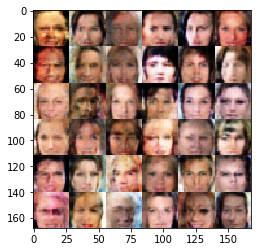

Epoch: 1, Batch: 3525: Discr train loss: 1.521, Gen train loss: 0.479
Epoch: 1, Batch: 3550: Discr train loss: 1.359, Gen train loss: 0.720
Epoch: 1, Batch: 3575: Discr train loss: 0.842, Gen train loss: 1.612
Epoch: 1, Batch: 3600: Discr train loss: 0.785, Gen train loss: 3.173


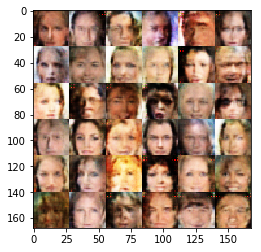

Epoch: 1, Batch: 3625: Discr train loss: 0.419, Gen train loss: 3.009
Epoch: 1, Batch: 3650: Discr train loss: 0.740, Gen train loss: 1.574
Epoch: 1, Batch: 3675: Discr train loss: 1.118, Gen train loss: 0.920
Epoch: 1, Batch: 3700: Discr train loss: 1.448, Gen train loss: 2.523


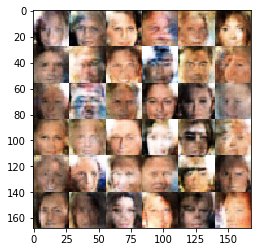

Epoch: 1, Batch: 3725: Discr train loss: 1.148, Gen train loss: 0.700
Epoch: 1, Batch: 3750: Discr train loss: 0.935, Gen train loss: 1.111
Epoch: 1, Batch: 3775: Discr train loss: 0.378, Gen train loss: 3.846
Epoch: 1, Batch: 3800: Discr train loss: 1.518, Gen train loss: 0.536


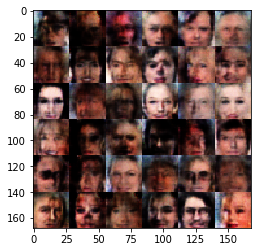

Epoch: 1, Batch: 3825: Discr train loss: 0.669, Gen train loss: 1.333
Epoch: 1, Batch: 3850: Discr train loss: 0.782, Gen train loss: 1.304
Epoch: 1, Batch: 3875: Discr train loss: 1.508, Gen train loss: 0.486
Epoch: 1, Batch: 3900: Discr train loss: 0.661, Gen train loss: 2.018


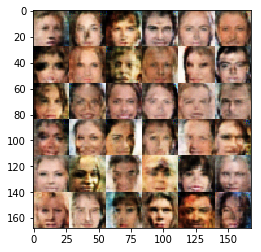

Epoch: 1, Batch: 3925: Discr train loss: 1.674, Gen train loss: 0.487
Epoch: 1, Batch: 3950: Discr train loss: 1.137, Gen train loss: 0.812
Epoch: 1, Batch: 3975: Discr train loss: 1.209, Gen train loss: 2.183
Epoch: 1, Batch: 4000: Discr train loss: 1.546, Gen train loss: 0.583


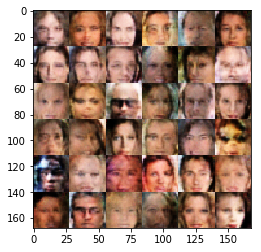

Epoch: 1, Batch: 4025: Discr train loss: 0.524, Gen train loss: 2.039
Epoch: 1, Batch: 4050: Discr train loss: 0.431, Gen train loss: 2.944
Epoch: 1, Batch: 4075: Discr train loss: 0.623, Gen train loss: 4.951
Epoch: 1, Batch: 4100: Discr train loss: 0.896, Gen train loss: 1.807


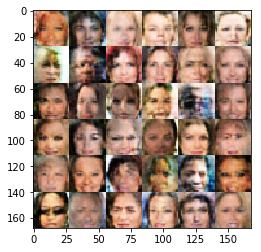

Epoch: 1, Batch: 4125: Discr train loss: 1.458, Gen train loss: 0.541
Epoch: 1, Batch: 4150: Discr train loss: 0.558, Gen train loss: 2.952
Epoch: 1, Batch: 4175: Discr train loss: 1.103, Gen train loss: 1.222
Epoch: 1, Batch: 4200: Discr train loss: 0.614, Gen train loss: 1.576


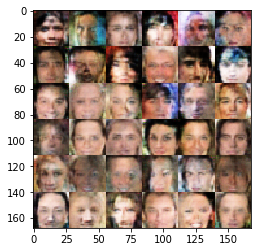

Epoch: 1, Batch: 4225: Discr train loss: 2.452, Gen train loss: 0.340
Epoch: 1, Batch: 4250: Discr train loss: 1.452, Gen train loss: 1.701
Epoch: 1, Batch: 4275: Discr train loss: 0.574, Gen train loss: 1.797
Epoch: 1, Batch: 4300: Discr train loss: 0.821, Gen train loss: 1.137


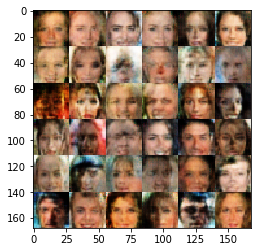

Epoch: 1, Batch: 4325: Discr train loss: 0.527, Gen train loss: 2.331
Epoch: 1, Batch: 4350: Discr train loss: 1.293, Gen train loss: 0.629
Epoch: 1, Batch: 4375: Discr train loss: 1.378, Gen train loss: 0.787
Epoch: 1, Batch: 4400: Discr train loss: 1.327, Gen train loss: 0.572


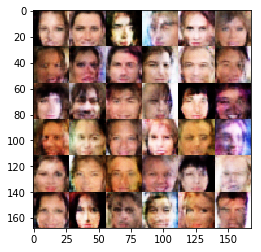

Epoch: 1, Batch: 4425: Discr train loss: 0.882, Gen train loss: 0.943
Epoch: 1, Batch: 4450: Discr train loss: 0.647, Gen train loss: 1.296
Epoch: 1, Batch: 4475: Discr train loss: 1.005, Gen train loss: 1.112
Epoch: 1, Batch: 4500: Discr train loss: 0.830, Gen train loss: 1.026


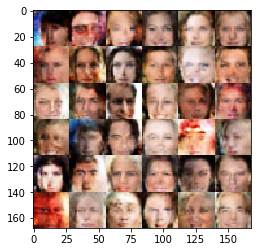

Epoch: 1, Batch: 4525: Discr train loss: 1.202, Gen train loss: 0.931
Epoch: 1, Batch: 4550: Discr train loss: 1.224, Gen train loss: 0.688
Epoch: 1, Batch: 4575: Discr train loss: 1.445, Gen train loss: 0.527
Epoch: 1, Batch: 4600: Discr train loss: 1.091, Gen train loss: 0.796


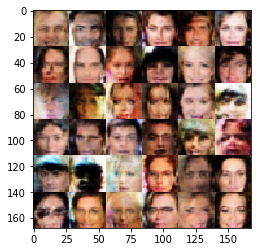

Epoch: 1, Batch: 4625: Discr train loss: 1.342, Gen train loss: 0.749
Epoch: 1, Batch: 4650: Discr train loss: 0.531, Gen train loss: 1.778
Epoch: 1, Batch: 4675: Discr train loss: 1.326, Gen train loss: 0.602
Epoch: 1, Batch: 4700: Discr train loss: 1.085, Gen train loss: 1.028


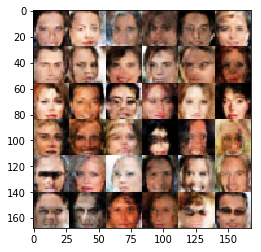

Epoch: 1, Batch: 4725: Discr train loss: 1.227, Gen train loss: 1.566
Epoch: 1, Batch: 4750: Discr train loss: 1.616, Gen train loss: 0.472
Epoch: 1, Batch: 4775: Discr train loss: 1.045, Gen train loss: 0.817
Epoch: 1, Batch: 4800: Discr train loss: 0.482, Gen train loss: 2.129


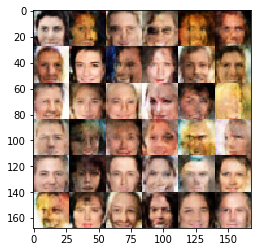

Epoch: 1, Batch: 4825: Discr train loss: 1.644, Gen train loss: 0.479
Epoch: 1, Batch: 4850: Discr train loss: 0.993, Gen train loss: 0.946
Epoch: 1, Batch: 4875: Discr train loss: 0.823, Gen train loss: 0.971
Epoch: 1, Batch: 4900: Discr train loss: 1.329, Gen train loss: 0.717


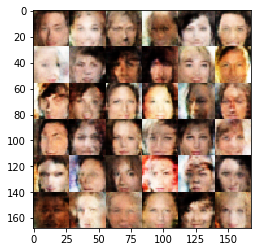

Epoch: 1, Batch: 4925: Discr train loss: 0.863, Gen train loss: 1.334
Epoch: 1, Batch: 4950: Discr train loss: 1.190, Gen train loss: 0.976
Epoch: 1, Batch: 4975: Discr train loss: 1.249, Gen train loss: 0.677
Epoch: 1, Batch: 5000: Discr train loss: 1.055, Gen train loss: 0.929


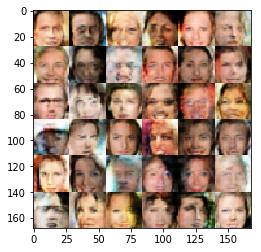

Epoch: 1, Batch: 5025: Discr train loss: 1.068, Gen train loss: 1.006
Epoch: 1, Batch: 5050: Discr train loss: 1.195, Gen train loss: 0.680
Epoch: 1, Batch: 5075: Discr train loss: 0.452, Gen train loss: 2.344
Epoch: 1, Batch: 5100: Discr train loss: 0.944, Gen train loss: 1.018


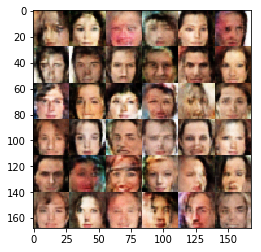

Epoch: 1, Batch: 5125: Discr train loss: 1.187, Gen train loss: 0.696
Epoch: 1, Batch: 5150: Discr train loss: 0.757, Gen train loss: 1.323
Epoch: 1, Batch: 5175: Discr train loss: 1.268, Gen train loss: 0.636
Epoch: 1, Batch: 5200: Discr train loss: 0.643, Gen train loss: 2.524


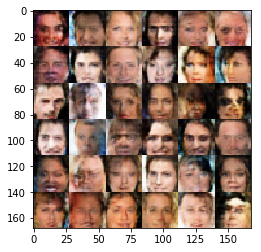

Epoch: 1, Batch: 5225: Discr train loss: 1.089, Gen train loss: 1.902
Epoch: 1, Batch: 5250: Discr train loss: 0.778, Gen train loss: 1.176
Epoch: 1, Batch: 5275: Discr train loss: 1.631, Gen train loss: 0.443
Epoch: 1, Batch: 5300: Discr train loss: 0.683, Gen train loss: 1.644


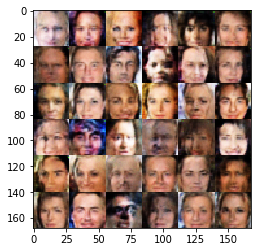

Epoch: 1, Batch: 5325: Discr train loss: 1.124, Gen train loss: 1.637
Epoch: 1, Batch: 5350: Discr train loss: 0.846, Gen train loss: 1.059
Epoch: 1, Batch: 5375: Discr train loss: 1.202, Gen train loss: 0.704
Epoch: 1, Batch: 5400: Discr train loss: 0.645, Gen train loss: 1.525


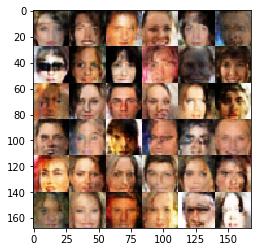

Epoch: 1, Batch: 5425: Discr train loss: 0.992, Gen train loss: 0.917
Epoch: 1, Batch: 5450: Discr train loss: 1.062, Gen train loss: 0.798
Epoch: 1, Batch: 5475: Discr train loss: 0.774, Gen train loss: 2.155
Epoch: 1, Batch: 5500: Discr train loss: 0.945, Gen train loss: 0.855


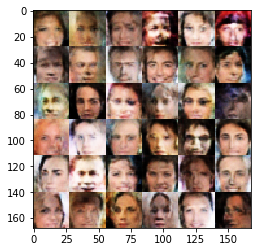

Epoch: 1, Batch: 5525: Discr train loss: 1.077, Gen train loss: 0.959
Epoch: 1, Batch: 5550: Discr train loss: 0.966, Gen train loss: 1.564
Epoch: 1, Batch: 5575: Discr train loss: 1.442, Gen train loss: 0.515
Epoch: 1, Batch: 5600: Discr train loss: 1.538, Gen train loss: 0.618


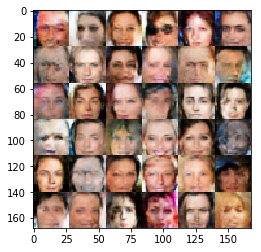

Epoch: 1, Batch: 5625: Discr train loss: 1.412, Gen train loss: 1.858
Epoch: 1, Batch: 5650: Discr train loss: 1.261, Gen train loss: 1.540
Epoch: 1, Batch: 5675: Discr train loss: 0.668, Gen train loss: 1.857
Epoch: 1, Batch: 5700: Discr train loss: 1.632, Gen train loss: 0.513


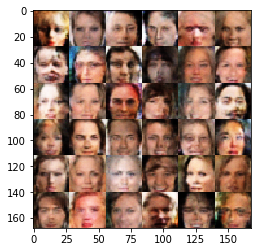

Epoch: 1, Batch: 5725: Discr train loss: 0.847, Gen train loss: 0.972
Epoch: 1, Batch: 5750: Discr train loss: 1.442, Gen train loss: 0.574
Epoch: 1, Batch: 5775: Discr train loss: 1.320, Gen train loss: 0.577
Epoch: 1, Batch: 5800: Discr train loss: 0.793, Gen train loss: 1.075


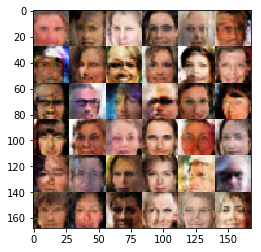

Epoch: 1, Batch: 5825: Discr train loss: 1.398, Gen train loss: 0.641
Epoch: 1, Batch: 5850: Discr train loss: 0.553, Gen train loss: 1.760
Epoch: 1, Batch: 5875: Discr train loss: 0.560, Gen train loss: 2.028
Epoch: 1, Batch: 5900: Discr train loss: 1.187, Gen train loss: 0.723


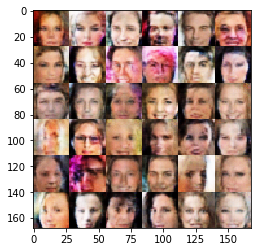

Epoch: 1, Batch: 5925: Discr train loss: 0.963, Gen train loss: 1.185
Epoch: 1, Batch: 5950: Discr train loss: 1.395, Gen train loss: 1.136
Epoch: 1, Batch: 5975: Discr train loss: 0.899, Gen train loss: 1.102
Epoch: 1, Batch: 6000: Discr train loss: 1.416, Gen train loss: 0.572


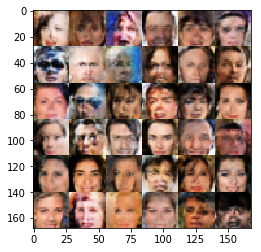

Epoch: 1, Batch: 6025: Discr train loss: 1.711, Gen train loss: 0.480
Epoch: 1, Batch: 6050: Discr train loss: 1.079, Gen train loss: 1.060
Epoch: 1, Batch: 6075: Discr train loss: 1.372, Gen train loss: 0.547
Epoch: 1, Batch: 6100: Discr train loss: 0.620, Gen train loss: 1.895


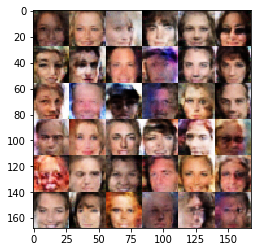

Epoch: 1, Batch: 6125: Discr train loss: 0.815, Gen train loss: 1.973
Epoch: 1, Batch: 6150: Discr train loss: 0.532, Gen train loss: 2.305
Epoch: 1, Batch: 6175: Discr train loss: 1.000, Gen train loss: 0.980
Epoch: 1, Batch: 6200: Discr train loss: 0.851, Gen train loss: 1.062


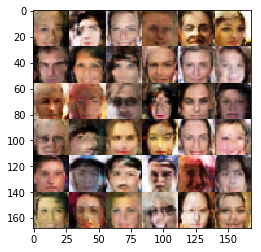

Epoch: 1, Batch: 6225: Discr train loss: 0.603, Gen train loss: 2.097
Epoch: 1, Batch: 6250: Discr train loss: 1.216, Gen train loss: 1.591
Epoch: 1, Batch: 6275: Discr train loss: 0.728, Gen train loss: 1.197
Epoch: 1, Batch: 6300: Discr train loss: 0.853, Gen train loss: 1.366


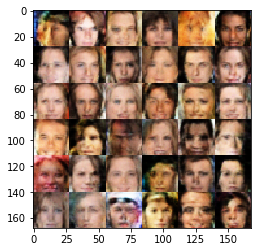

Epoch: 1, Batch: 6325: Discr train loss: 0.458, Gen train loss: 2.490


In [14]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.